In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import sqlalchemy as sq
import seaborn as sns

import sqlite3

In [6]:
events = pd.read_csv("/Users/evanvolpini/Desktop/athlete_events.csv")

In [7]:
regions = pd.read_csv("/Users/evanvolpini/Desktop/noc_regions.csv")

# creating a connection to use sql queries


In [8]:
!pip install ipython-sql;


In [9]:
cn = sqlite3.connect('test2.db')


In [10]:
#load sql module to ipython
%load_ext sql


In [11]:
%sql sqlite:///test2.db

In [12]:
events.head()

ID                      Name Sex   Age  Height  Weight            Team  \
0   1                 A Dijiang   M  24.0   180.0    80.0           China   
1   2                  A Lamusi   M  23.0   170.0    60.0           China   
2   3       Gunnar Nielsen Aaby   M  24.0     NaN     NaN         Denmark   
3   4      Edgar Lindenau Aabye   M  34.0     NaN     NaN  Denmark/Sweden   
4   5  Christine Jacoba Aaftink   F  21.0   185.0    82.0     Netherlands   

   NOC        Games  Year  Season       City          Sport  \
0  CHN  1992 Summer  1992  Summer  Barcelona     Basketball   
1  CHN  2012 Summer  2012  Summer     London           Judo   
2  DEN  1920 Summer  1920  Summer  Antwerpen       Football   
3  DEN  1900 Summer  1900  Summer      Paris     Tug-Of-War   
4  NED  1988 Winter  1988  Winter    Calgary  Speed Skating   

                              Event Medal  
0       Basketball Men's Basketball   NaN  
1      Judo Men's Extra-Lightweight   NaN  
2           Football Men's Football   NaN  
3       Tug-Of-War Men's Tug-Of-War  Gold  
4  Speed Skating Women's 500 metres   NaN

In [13]:
regions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230 entries, 0 to 229
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   NOC     230 non-null    object
 1   region  227 non-null    object
 2   notes   21 non-null     object
dtypes: object(3)
memory usage: 5.5+ KB


# Introduction

For this Analysis we will attempt to explain my hypotheses and to see if the data supports them. They are

1. Athletes who are taller and heavier tend to win more medals.

2. Certain countries or regions are consistently more successful in certain sports than others.

### 1. Gathering our Data

as we can only track results based on medals, entries must have either bronze, silver or gold which we will denote as 'Won Medal'.

In [45]:
#retrieve the data from SQL
events_table = pd.read_sql(
'''
SELECT 
    CASE 
        WHEN Medal IS NOT NULL THEN 'Won Medal' 
        ELSE 'No Medal' 
    END AS Medal_Outcome,
    Height,
    Weight
FROM 
    events
WHERE 
    Height IS NOT NULL 
    AND Weight IS NOT NULL
    ''', con=cn
)

In [49]:
events_table

Medal_Outcome  Height  Weight
0           No Medal   180.0    80.0
1           No Medal   170.0    60.0
2           No Medal   185.0    82.0
3           No Medal   185.0    82.0
4           No Medal   185.0    82.0
...              ...     ...     ...
206848      No Medal   179.0    89.0
206849      No Medal   176.0    59.0
206850      No Medal   176.0    59.0
206851      No Medal   185.0    96.0
206852      No Medal   185.0    96.0

[206853 rows x 3 columns]

And for our second hypothesis we can gather data. We need the columns
team, region, city, sport, Medal

In [127]:
regions_table = pd.read_sql(
    '''
SELECT
    regions.region,
    events.City,
    events.Sport,
    events.Medal,
    events.Games
FROM
    events
    LEFT JOIN regions ON events.NOC = regions.NOC
WHERE
    events.Medal IN ('Gold', 'Silver', 'Bronze')
''', con=cn)


In [128]:
regions_table

region       City       Sport   Medal        Games
0      Denmark      Paris  Tug-Of-War    Gold  1900 Summer
1      Finland  Antwerpen    Swimming  Bronze  1920 Summer
2      Finland  Antwerpen    Swimming  Bronze  1920 Summer
3      Finland      Sochi  Ice Hockey  Bronze  2014 Winter
4      Finland     London  Gymnastics  Bronze  1948 Summer
...        ...        ...         ...     ...          ...
39778   Russia  Melbourne   Athletics  Silver  1956 Summer
39779   Russia      Tokyo   Athletics  Bronze  1964 Summer
39780   Poland     Moskva     Fencing  Bronze  1980 Summer
39781   Russia     Sydney   Athletics  Bronze  2000 Summer
39782   Russia     Athina   Athletics  Silver  2004 Summer

[39783 rows x 5 columns]

### 2.1 Data Analysis



We will begin our analysis by exploring our first hypothesis. (heigh/weight vs. medals)

In [ ]:
#1. scatter plot of height weight and medals. different colours 

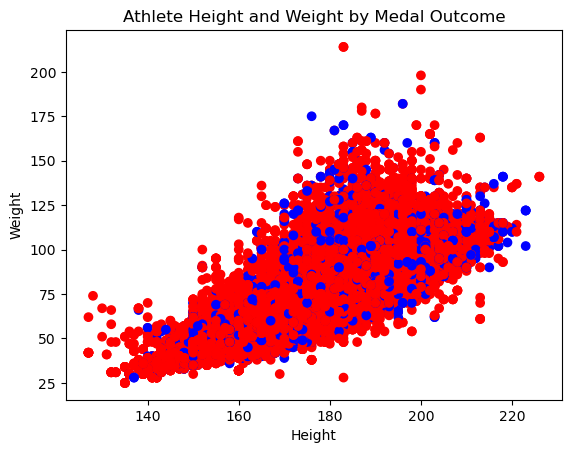

In [52]:

# Create scatter plot
fig, ax = plt.subplots()
colors = {'Won Medal':'blue', 'No Medal':'red'}
ax.scatter(events_table['Height'], events_table['Weight'], c=pd.Series(events_table['Medal_Outcome']).apply(lambda x: colors[x]))


ax.set_title('Athlete Height and Weight by Medal Outcome')
ax.set_xlabel('Height')
ax.set_ylabel('Weight')

plt.show()


/var/folders/6b/q9f13svs5352_59frhhcz_9h0000gn/T/ipykernel_59362/1707186648.py:22: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.boxplot(column=['Height', 'Weight'], by='Medal_Outcome', ax=axes)


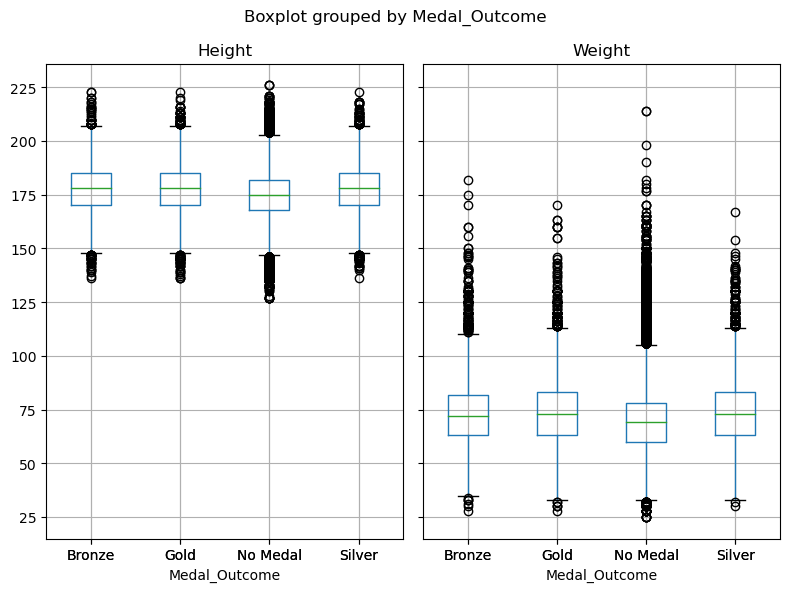

In [57]:

# Retrieving data from SQL
df = pd.read_sql_query(
    '''
    SELECT 
        CASE 
            WHEN Medal = 'Gold' THEN 'Gold'
            WHEN Medal = 'Silver' THEN 'Silver'
            WHEN Medal = 'Bronze' THEN 'Bronze'
            ELSE 'No Medal' 
        END AS Medal_Outcome,
        Height,
        Weight
    FROM 
        events
    WHERE 
        Height IS NOT NULL 
        AND Weight IS NOT NULL
''', con=cn)

# Create box plot
fig, axes = plt.subplots(figsize=(8, 6))
df.boxplot(column=['Height', 'Weight'], by='Medal_Outcome', ax=axes)


axes.set_title('Athlete Height and Weight by Medal Outcome')
axes.set_xlabel('Medal Outcome')
axes.set_ylabel('Height and Weight')

plt.tight_layout()
plt.show()


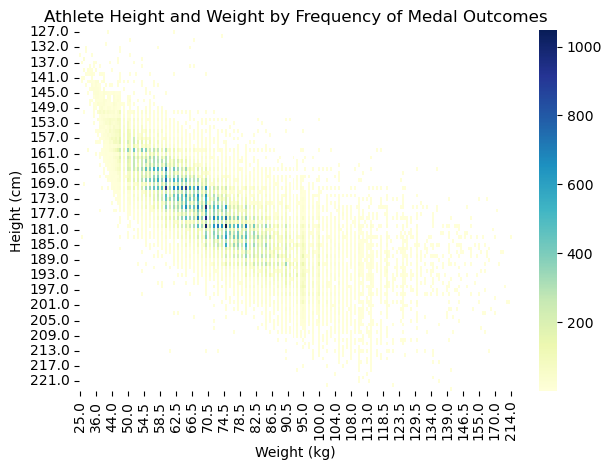

In [58]:
# Retrieve data from SQL
df = pd.read_sql_query('''
    SELECT 
        Height,
        Weight,
        COUNT(*) AS Frequency
    FROM 
        events
    WHERE 
        Height IS NOT NULL 
        AND Weight IS NOT NULL
    GROUP BY 
        Height,
        Weight
''', con=cn)

# Create heatmap
pivot_df = df.pivot(index='Height', columns='Weight', values='Frequency')
sns.heatmap(pivot_df, cmap='YlGnBu')

plt.title('Athlete Height and Weight by Frequency of Medal Outcomes')
plt.xlabel('Weight (kg)')
plt.ylabel('Height (cm)')

plt.tight_layout()
plt.show()


it can be noted that there is no clear pattern indicating that heavier/taller people win more medals.
We see that there is a zone in which most medals are won (161cm-189cm & 50-86kg)


conclusion: there seems to be no correlation between height/weight & winnings.

Even though there is some variability, which is to be expected as there are much more athletes who do not win medals, this still does not show us that there is a relationship.

However we can also mesure correlation between height and wins for a more common sport like basketball

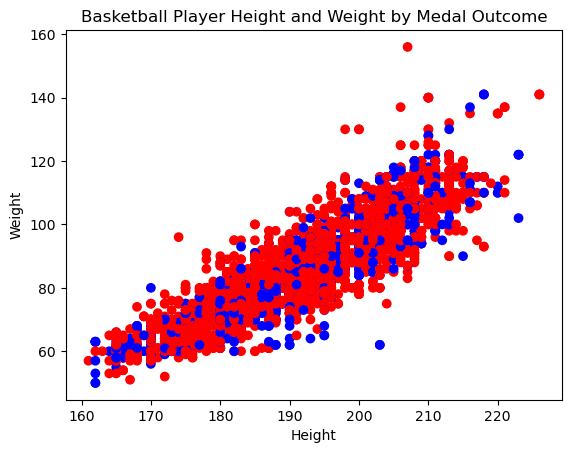

In [63]:

# Retrieve data from SQL
df = pd.read_sql_query('''
    SELECT 
        CASE 
            WHEN Medal IS NOT NULL THEN 'Won Medal' 
            ELSE 'No Medal' 
        END AS Medal_Outcome,
        Height,
        Weight
    FROM 
        events
    WHERE 
        Height IS NOT NULL 
        AND Weight IS NOT NULL
        AND Sport = 'Basketball'
''', con=cn)

# Create scatter plot
fig, ax = plt.subplots()
colors = {'Won Medal':'blue', 'No Medal':'red'}
ax.scatter(df['Height'], df['Weight'], c=df['Medal_Outcome'].apply(lambda x: colors[x]))

ax.set_title('Basketball Player Height and Weight by Medal Outcome')
ax.set_xlabel('Height')
ax.set_ylabel('Weight')

plt.show()


/var/folders/6b/q9f13svs5352_59frhhcz_9h0000gn/T/ipykernel_59362/4219693178.py:23: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.boxplot(column=['Height', 'Weight'], by='Medal_Outcome', ax=axes)


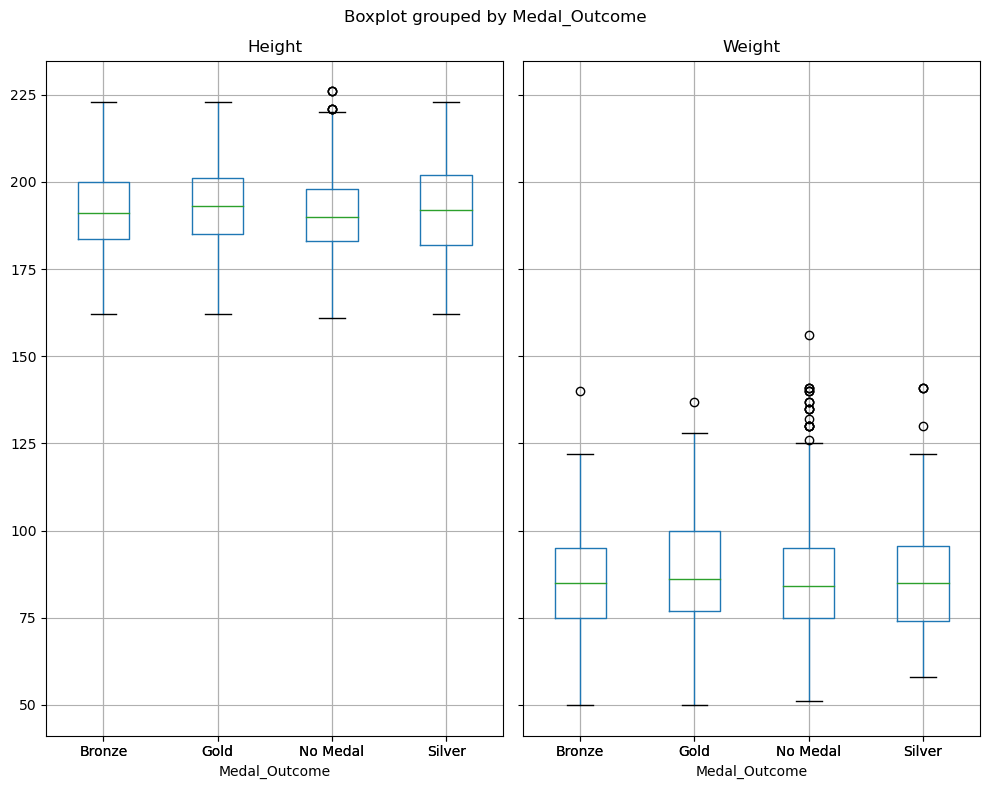

In [74]:
# Retrieving data from SQL
df = pd.read_sql_query(
    '''
    SELECT 
        CASE 
            WHEN Medal = 'Gold' THEN 'Gold'
            WHEN Medal = 'Silver' THEN 'Silver'
            WHEN Medal = 'Bronze' THEN 'Bronze'
            ELSE 'No Medal' 
        END AS Medal_Outcome,
        Height,
        Weight
    FROM 
        events
    WHERE 
        Height IS NOT NULL 
        AND Weight IS NOT NULL
        AND Sport = 'Basketball'
''', con=cn)

# Create box plot
fig, axes = plt.subplots(figsize=(10, 8))
df.boxplot(column=['Height', 'Weight'], by='Medal_Outcome', ax=axes)

# Adjust y-axis limits
axes.set_ylim([100, 250])
axes.set_ylim([40, 150])


axes.set_title('Basketball Player Height and Weight by Medal Outcome')
axes.set_xlabel('Medal Outcome')
axes.set_ylabel('Height and Weight')

plt.tight_layout()
plt.show()


We note a slightly lower height and weight for those who achieve no medal. We can view more closely if this is the case with a column chart.

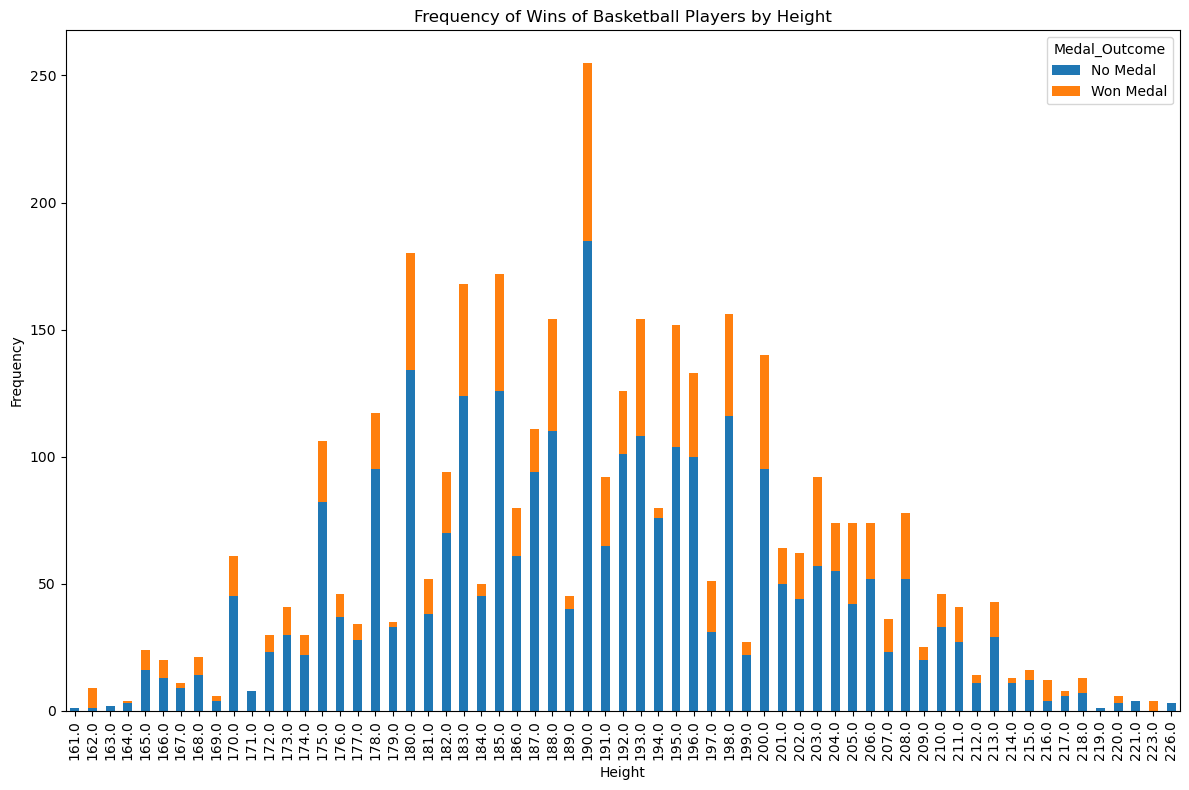

In [76]:
# Retrieving data from SQL
df = pd.read_sql_query(
    '''
    SELECT 
        CASE 
            WHEN Medal IS NOT NULL THEN 'Won Medal' 
            ELSE 'No Medal' 
        END AS Medal_Outcome,
        Height
    FROM 
        events
    WHERE 
        Height IS NOT NULL 
        AND Sport = 'Basketball'
''', con=cn)

# Group the data by height and medal outcome, and count the number of occurrences of each medal outcome
counts = df.groupby(['Height', 'Medal_Outcome']).size().unstack(fill_value=0)

# Plot the data
counts.plot(kind='bar', stacked=True, figsize=(12,8))

plt.title('Frequency of Wins of Basketball Players by Height')
plt.xlabel('Height')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()



We see a fairly normal distribution and we can see that most winning players are within the 180 to 200 cm height zone.

We should investigate this more with only Male basketball player.

If there is no correlaiton between height and win frequency then we should see normally distributed data.

In [17]:
# Retrieving data from SQL
df = pd.read_sql_query(
    '''
    SELECT 
        Height
    FROM 
        events
    WHERE 
        Height IS NOT NULL 
        AND Sport = 'Basketball'
        AND Sex ='M'
''', con=cn)

# Compute mean, median, and standard deviation
mean = df['Height'].mean()
median = df['Height'].median()
std = df['Height'].std()

print("Mean height: {:.2f} cm".format(mean))
print("Median height: {:.2f} cm".format(median))
print("Standard deviation: {:.2f} cm".format(std))


Mean height: 194.87 cm
Median height: 195.00 cm
Standard deviation: 10.32 cm


For positive correlation between Height and winnings we should expect a higher average & median height for winning players than losing players.

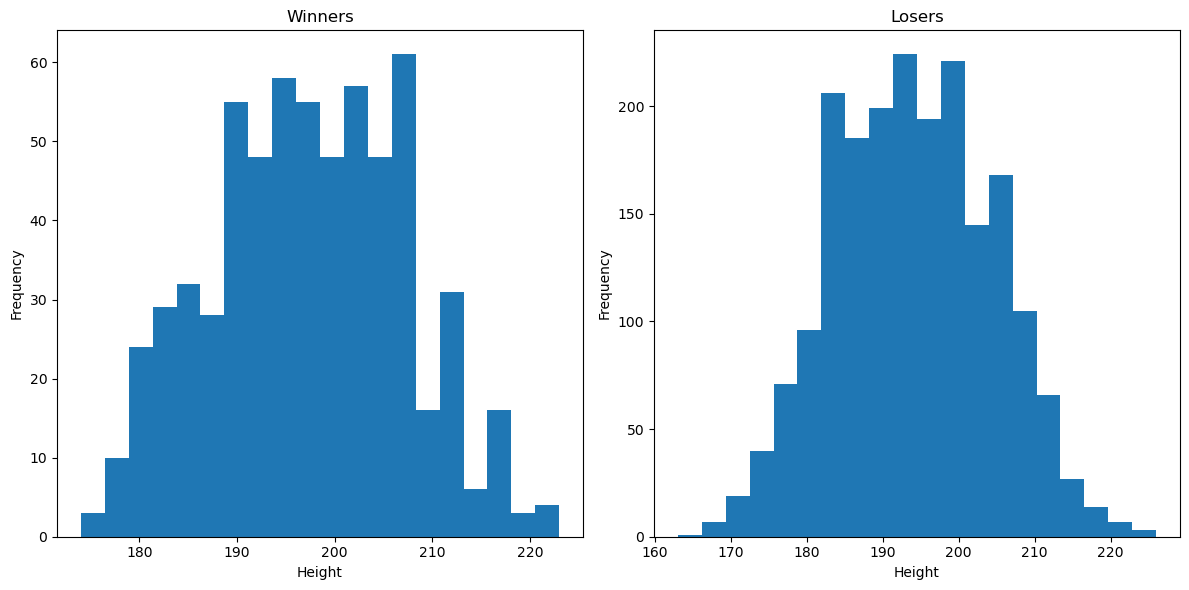

In [16]:
# Retrieving data from SQL
winners = pd.read_sql_query(
    '''
    SELECT 
        Height
    FROM 
        events
    WHERE 
        Height IS NOT NULL 
        AND Sport = 'Basketball'
        AND Sex ='M'
        AND Medal IS NOT NULL
''', con=cn)

losers = pd.read_sql_query(
    '''
    SELECT 
        Height
    FROM 
        events
    WHERE 
        Height IS NOT NULL 
        AND Sport = 'Basketball'
        AND Sex ='M'
        AND Medal IS NULL
''', con=cn)


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.hist(winners['Height'], bins=20)
ax1.set_title('Winners')
ax1.set_xlabel('Height')
ax1.set_ylabel('Frequency')

ax2.hist(losers['Height'], bins=20)
ax2.set_title('Losers')
ax2.set_xlabel('Height')
ax2.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


We observe a slight chunk of men who are taller that have more frequent wins. We can investigate further by finding numerical summaries to make sure

In [21]:
# Retrieving data from SQL for winners
df_winners = pd.read_sql_query(
    '''
    SELECT 
        Height
    FROM 
        events
    WHERE 
        Height IS NOT NULL 
        AND Sport = 'Basketball'
        AND Sex ='M'
        AND Medal IS NOT NULL
''', con=cn)

# Retrieving data from SQL for losers
df_losers = pd.read_sql_query(
    '''
    SELECT 
        Height
    FROM 
        events
    WHERE 
        Height IS NOT NULL 
        AND Sport = 'Basketball'
        AND Sex ='M'
        AND Medal IS NULL
''', con=cn)

# Compute mean, median, and standard deviation for winners
win_mean = df_winners['Height'].mean()
win_median = df_winners['Height'].median()
win_std = df_winners['Height'].std()

# Compute mean, median, and standard deviation for losers
lose_mean = df_losers['Height'].mean()
lose_median = df_losers['Height'].median()
lose_std = df_losers['Height'].std()


print("Height statistics for male basketball players who won a medal:")
print("Mean height: {:.2f} cm".format(win_mean))
print("Median height: {:.2f} cm".format(win_median))
print("Standard deviation: {:.2f} cm".format(win_std))

print("\nHeight statistics for male basketball players who did not win a medal:")
print("Mean height: {:.2f} cm".format(lose_mean))
print("Median height: {:.2f} cm".format(lose_median))
print("Standard deviation: {:.2f} cm".format(lose_std))



Height statistics for male basketball players who won a medal:
Mean height: 197.56 cm
Median height: 198.00 cm
Standard deviation: 9.83 cm

Height statistics for male basketball players who did not win a medal:
Mean height: 194.02 cm
Median height: 194.00 cm
Standard deviation: 10.33 cm


We have the following results:

All Male basketball players:
Mean height: 194.87 cm
Median height: 195.00 cm
Standard deviation: 10.32 cm
    
Height statistics for male basketball players who won a medal:
Mean height: 197.56 cm
Median height: 198.00 cm
Standard deviation: 9.83 cm

Height statistics for male basketball players who did not win a medal:
Mean height: 194.02 cm
Median height: 194.00 cm
Standard deviation: 10.33 cm
    
    
    
Thus, We can see that taller players win more medals on average if the are 4 cm taller median.

Also there is some variance in the mean & median height in winning players which suggest that there are more winning players are taller than the average winning player. However, there is only a 0.5cm difference from the mean so this is negligeable. Also note how all of the standard deviations are relatively the same, 10 cm. Thus we can compare them without any issue.

# 2.2 Data Analysis

Now, we may attempt to investigate if certain countries/regions are more successful
in certain sports. 

First, we should define "success".

We could say that sucess is: 

the # of medals won in each sport by country/region

First, we may simply visualise the medal count for each country as well as which countries won the most medals.

In [101]:

medal_count = pd.read_sql(
    '''

SELECT
    regions.region,
    COUNT(*) AS medal_count
FROM
    events
    LEFT JOIN regions ON events.NOC = regions.NOC
WHERE
    events.Medal IN ('Gold', 'Silver', 'Bronze')
GROUP BY
    regions.region
ORDER BY
    medal_count DESC
    ''', con=cn)



In [102]:
medal_count

region  medal_count
0         USA         5637
1      Russia         3947
2     Germany         3756
3          UK         2068
4      France         1777
..        ...          ...
132    Cyprus            1
133   Curacao            1
134  Botswana            1
135   Bermuda            1
136  Barbados            1

[137 rows x 2 columns]

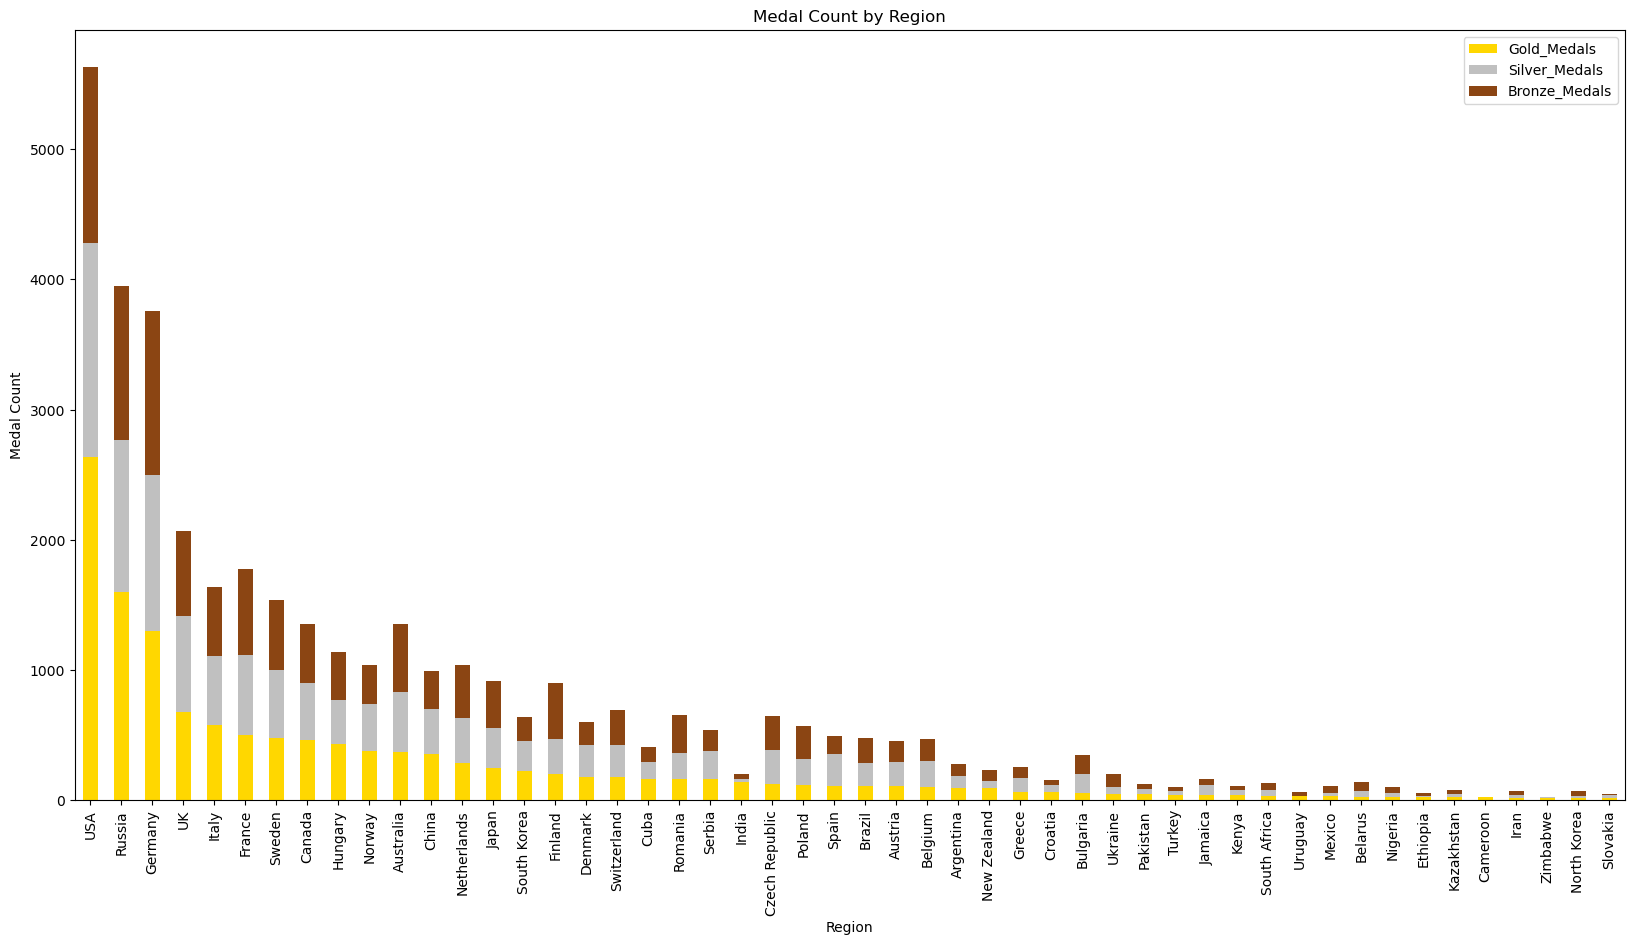

In [126]:
import pandas as pd
import matplotlib.pyplot as plt

# Retrieve data from SQL
df = pd.read_sql_query('''
    SELECT 
        regions.region, 
        COUNT(CASE WHEN events.Medal = 'Gold' THEN 1 ELSE NULL END) AS Gold_Medals,
        COUNT(CASE WHEN events.Medal = 'Silver' THEN 1 ELSE NULL END) AS Silver_Medals,
        COUNT(CASE WHEN events.Medal = 'Bronze' THEN 1 ELSE NULL END) AS Bronze_Medals
    FROM 
        events
        LEFT JOIN regions ON events.NOC = regions.NOC
    WHERE 
        events.Medal IN ('Gold', 'Silver', 'Bronze')
    GROUP BY 
        regions.region
    ORDER BY 
        Gold_Medals DESC
        LIMIT 50
''', con=cn)

#To get the region names on X axis
df.set_index('region', inplace=True)

# Create stacked column chart
ax = df.plot(kind='bar', stacked=True, figsize=(20, 10), color=['gold', 'silver', 'saddlebrown'])
ax.set_title('Medal Count by Region')
ax.set_xlabel('Region')
ax.set_ylabel('Medal Count')

plt.show()


So, we can clearly see that USA, Russia, Germany have won the most medals. Now, we will continue to investigate if there are dominant countries in certain sports


In [137]:


import matplotlib.pyplot as plt
import seaborn as sns

# Retrieve data from SQL
regions3 = pd.read_sql_query(
    '''
    SELECT
        regions.region,
        events.City,
        events.Sport,
        events.Medal,
        events.Games
    FROM
        events
        LEFT JOIN regions ON events.NOC = regions.NOC
    WHERE
        events.Medal IN ('Gold', 'Silver', 'Bronze')
    ''', con=cn)


In [139]:
regions3

region       City       Sport   Medal        Games
0      Denmark      Paris  Tug-Of-War    Gold  1900 Summer
1      Finland  Antwerpen    Swimming  Bronze  1920 Summer
2      Finland  Antwerpen    Swimming  Bronze  1920 Summer
3      Finland      Sochi  Ice Hockey  Bronze  2014 Winter
4      Finland     London  Gymnastics  Bronze  1948 Summer
...        ...        ...         ...     ...          ...
39778   Russia  Melbourne   Athletics  Silver  1956 Summer
39779   Russia      Tokyo   Athletics  Bronze  1964 Summer
39780   Poland     Moskva     Fencing  Bronze  1980 Summer
39781   Russia     Sydney   Athletics  Bronze  2000 Summer
39782   Russia     Athina   Athletics  Silver  2004 Summer

[39783 rows x 5 columns]

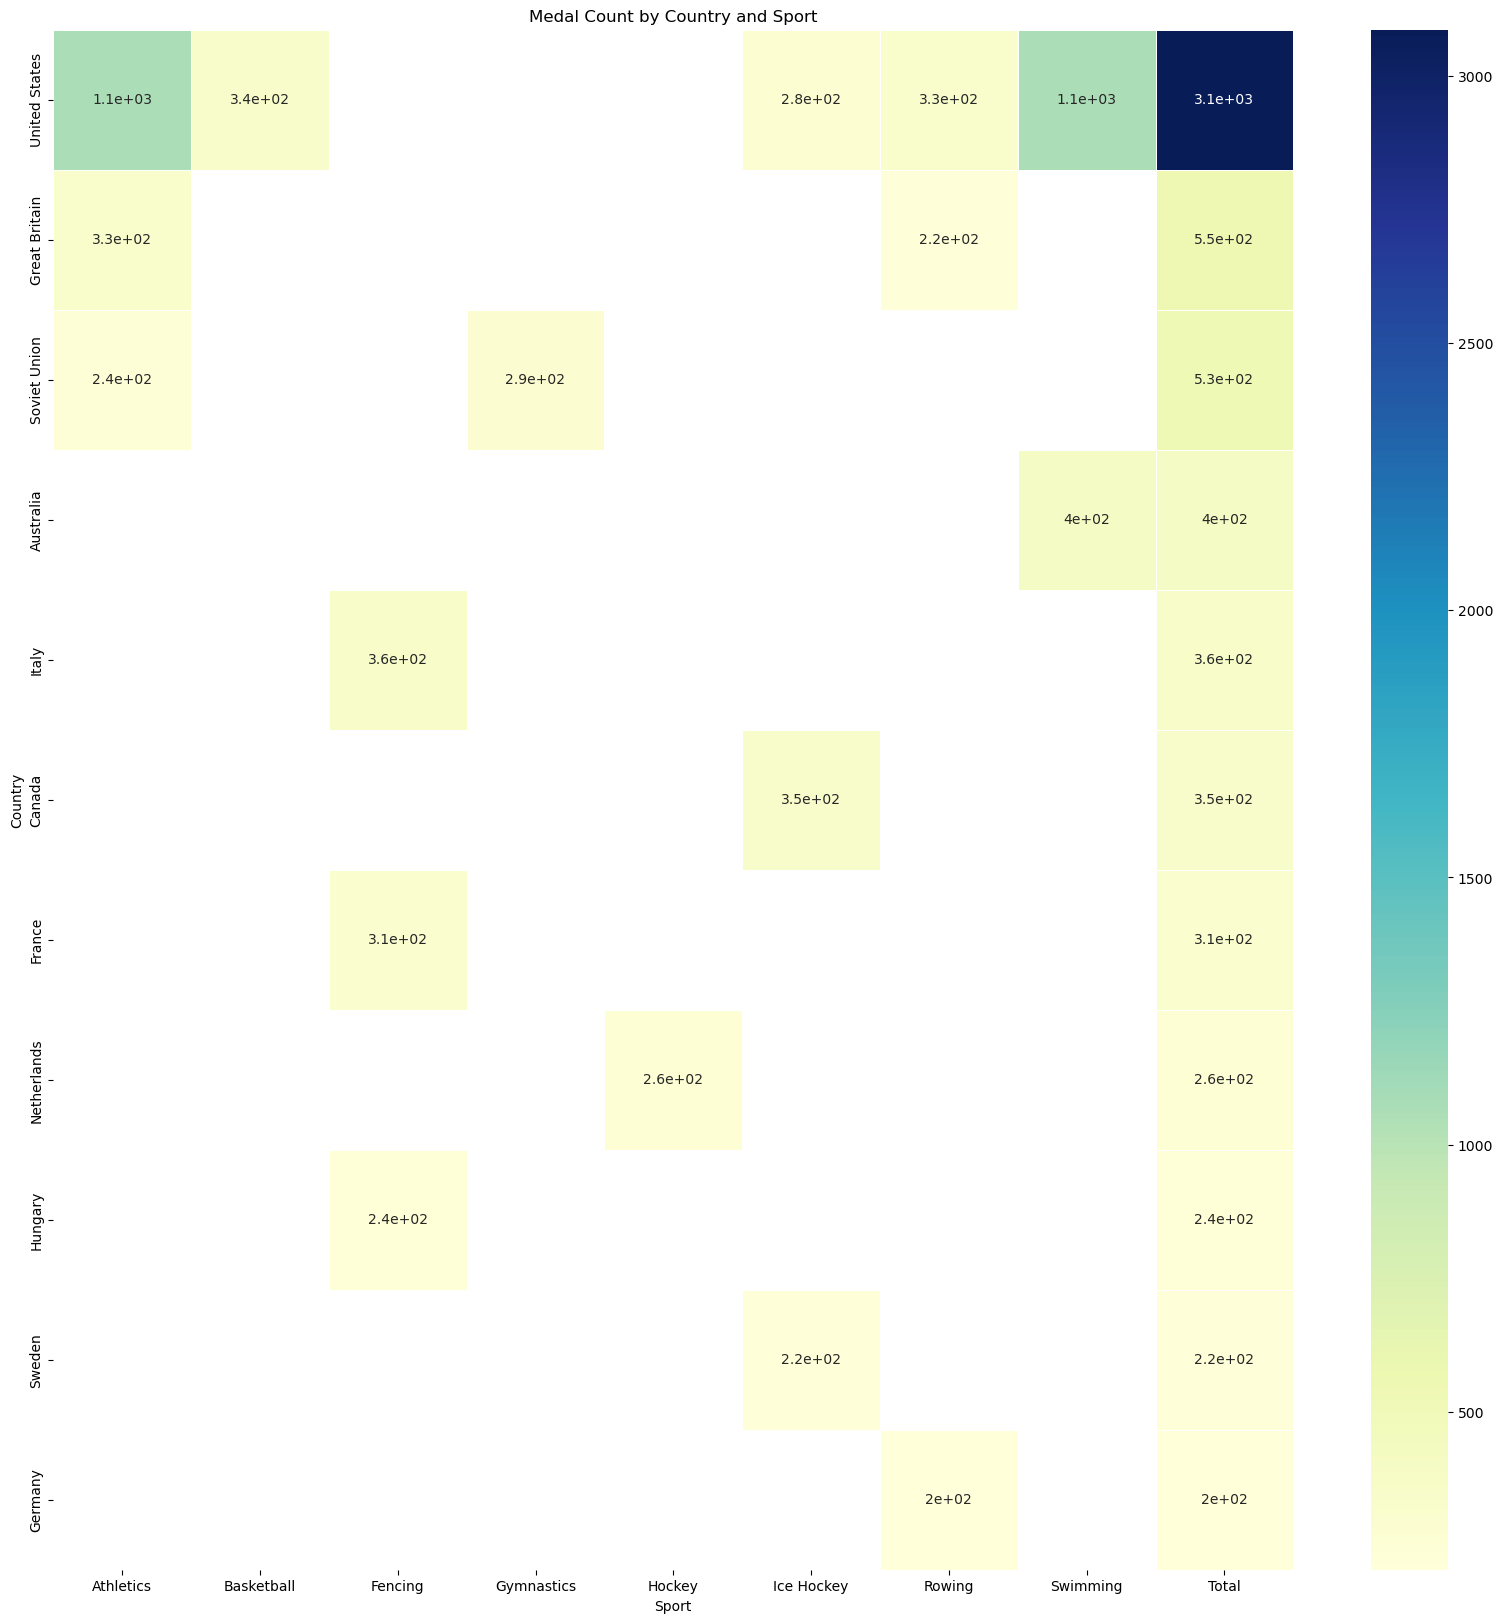

In [153]:
# Retrieve data from SQL
df = pd.read_sql_query('''
    SELECT 
        events.Team AS country, 
        events.Sport, 
        COUNT(CASE WHEN events.Medal IN ('Gold', 'Silver', 'Bronze') THEN 1 END) AS Medal_Count
    FROM 
        events
    WHERE 
        events.Medal IN ('Gold', 'Silver', 'Bronze')
    GROUP BY 
        events.Team, 
        events.Sport
    HAVING
        Medal_Count >200
''', con=cn)

# Pivot the table to create a matrix of countries and sports
df = df.pivot(index='country', columns='Sport', values='Medal_Count')

# Sort by total number of medals won by each country
df['Total'] = df.sum(axis=1)
df = df.sort_values(by='Total', ascending=False)

# Display only the top 20 countries
df = df.head(20)

# Create a heatmap plot
fig, ax = plt.subplots(figsize=(20,20))
sns.heatmap(df, annot=True, cmap='YlGnBu', linewidths=.5, ax=ax)

ax.set_title('Medal Count by Country and Sport')
ax.set_xlabel('Sport')
ax.set_ylabel('Country')

plt.show()




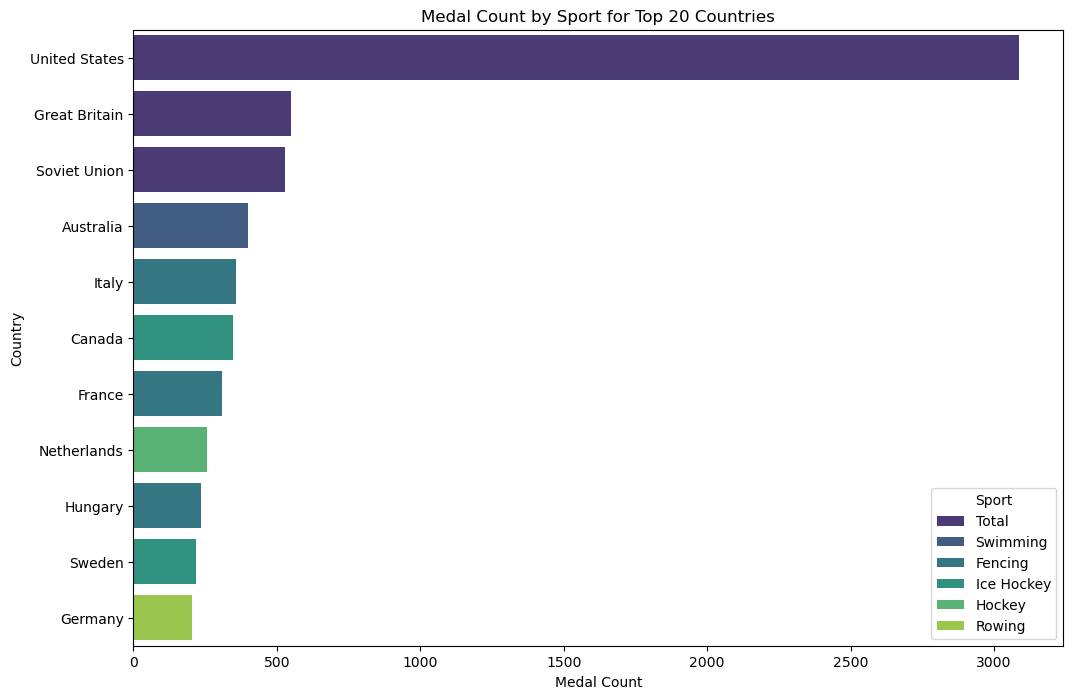

In [170]:
# Retrieve data from SQL
df = pd.read_sql_query('''
    SELECT 
        events.Team AS country, 
        events.Sport, 
        COUNT(CASE WHEN events.Medal IN ('Gold', 'Silver', 'Bronze') THEN 1 END) AS Medal_Count
    FROM 
        events
    WHERE 
        events.Medal IN ('Gold', 'Silver', 'Bronze')
    GROUP BY 
        events.Team, 
        events.Sport
    HAVING
        Medal_Count >200
''', con=cn)

# Pivot the table to create a matrix of countries and sports
df = df.pivot(index='country', columns='Sport', values='Medal_Count')

# Sort by total number of medals won by each country
df['Total'] = df.sum(axis=1)
df = df.sort_values(by='Total', ascending=False)

# Display only the top 20 countries
df = df.head(20)

# Get the name of the sport with the highest medal count for each country
max_sport = df.idxmax(axis=1)

# Create a new DataFrame with that information
df_max = pd.DataFrame({'Sport': max_sport.values, 'Medal_Count': df.max(axis=1).values}, index=max_sport.index)

# Sort by medal count
df_max = df_max.sort_values(by='Medal_Count', ascending=False)

# Create a bar plot of medal count by sport for each country
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='Medal_Count', y=df_max.index, hue='Sport', data=df_max, dodge=False, palette='viridis')

ax.set_title('Medal Count by Sport for Top 20 Countries')
ax.set_xlabel('Medal Count')
ax.set_ylabel('Country')

plt.show()




With usa, Great Britain athletics and the soviet union

having there top sport being Atheltics, Athletics and Gymnastics respectively


# Conclusion

We have found out that there is correlation between the heights of male basketball players and their heights.

Also, it is clear that countries have dominant(specialize) in certain sports and their medal count is not spread out accros all sports.



Some next steps to analyze:
    Does height in basketball apply to all regions of the world
    Why does the particular country have more medals in a certain sports
